In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn import metrics
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from tools import (COLUMNS_QUANT, COLUMNS_CAT, datasets)
from kneed import KneeLocator
import json


f3_scorer = metrics.make_scorer(metrics.fbeta_score, beta=3)
f5_scorer = metrics.make_scorer(metrics.fbeta_score, beta=5)

pd.options.display.max_rows = 80

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

In [3]:
datasets_df = datasets(df)
X_quant_scaled = datasets_df['X_quant_scaled']
X_scaled = datasets_df['X_scaled']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


## Régression logistique

L'avantage de cette méthode est qu'elle dépend du modèle utilisé.

### Méthode RFE

In [4]:
def run_RFE(model, n_features_to_select, X, y, export=None):
    # create the RFE model and select 3 attributes
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X, y)

    # summarize the selection of the attributes
    #  print(rfe.support_)
    #  print(rfe.ranking_)
    
    dico = {"Rank": rfe.ranking_,
            "Support": rfe.support_}
    rf_df = pd.DataFrame(dico, index=X.columns).sort_values(by='Rank', ascending=True)

    display(rf_df)
    
    support = rf_df[rf_df.Support == True].index.to_list()
    
    columns_quant = list(set(support).intersection(set(COLUMNS_QUANT)))
    
    columns_cat = list(set(support).difference(set(COLUMNS_QUANT)))
    
    print("Columns_quant :")
    display(columns_quant)
    print("\nColumns_cat :")
    display(columns_cat)    
    
    if export:        
        dico_export = {'columns_quant': columns_quant,
                   'columns_cat': columns_cat}
        with open(f"backups/{export}.json", 'w') as f:
            json.dump(dico_export, f)
        print(f"\nExportation : backups/{export}.json")

In [5]:
%%time
model = LogisticRegression()
df = run_RFE(model, 8, X_quant_scaled, y)

,Rank,Support
campaignctrlast24h,1,True
ltf_nbpartnerdisplayssincelastclick,1,True
ltf_nbpartnerclick_90d,1,True
nbdayssincelastclick,1,True
nbdisplay_1hour,1,True
nbdisplayglobalapprox_1d_sum_xdevice,1,True
display_size,1,True
zonecostineuro,1,True
dayssincelastvisitdouble,2,False
contextid,3,False


Columns_quant :


['ltf_nbpartnerdisplayssincelastclick',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'ltf_nbpartnerclick_90d',
 'display_size',
 'campaignctrlast24h',
 'zonecostineuro']


Columns_cat :


[]

CPU times: user 1min 47s, sys: 5min 49s, total: 7min 37s
Wall time: 29.4 s


In [6]:
%%time
model = LogisticRegression()
run_RFE(model, 3, X_quant_scaled, y)

,Rank,Support
campaignctrlast24h,1,True
display_size,1,True
zonecostineuro,1,True
nbdisplay_1hour,2,False
nbdayssincelastclick,3,False
nbdisplayglobalapprox_1d_sum_xdevice,4,False
ltf_nbpartnerdisplayssincelastclick,5,False
ltf_nbpartnerclick_90d,6,False
dayssincelastvisitdouble,7,False
contextid,8,False


Columns_quant :


['display_size', 'campaignctrlast24h', 'zonecostineuro']


Columns_cat :


[]

CPU times: user 2min 48s, sys: 9min 44s, total: 12min 32s
Wall time: 47 s


Pour ne pas avoir à définir un nombre de features, nous allons utiliser une méthode de Cross Validation qui permettra de calculer le nombre de features optimal.

### Méthode RFECV

In [7]:
def run_RFECV(model, X, y, score=f3_scorer, min_features_to_select=1, n_jobs=-1, knee=False):

    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
                  scoring=score,
                  min_features_to_select=min_features_to_select,
                  n_jobs=n_jobs)
    rfecv.fit(X, y)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Nombre de variables sélectionnées")
    if score == f3_scorer:
        plt.ylabel(f"Score F3 moyen")
    else:
        plt.ylabel(f"Score {str(score)} moyen")
    x = range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select)
    y = rfecv.grid_scores_
    plt.plot(x, y)
    if type(knee) == bool and knee:
        kneedle = KneeLocator(x, y)
        plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", color='black', label="Coude")
    if type(knee) == int:
        plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", color='black', label="Coude")
    plt.show()

    if type(knee) == bool and knee:
        print(f"Nombre optimal de variables à sélectionner (coude) : {kneedle.knee}")
        return kneedle.knee
    if type(knee) == int:
        print(f"Nombre optimal de variables à sélectionner (coude) : {knee}")
        return knee

#### Variables quantitatives

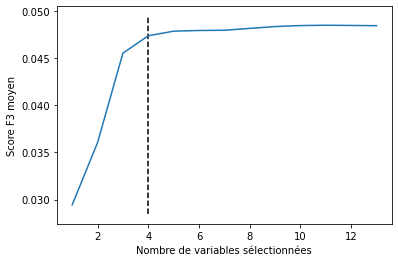

Nombre optimal de variables à sélectionner (coude) : 4
CPU times: user 1min 16s, sys: 4min 19s, total: 5min 35s
Wall time: 1min 7s


In [8]:
%%time
model = LogisticRegression()
knee = run_RFECV(model, X_quant_scaled, y, score=f3_scorer, knee=True, n_jobs=28)

Le nombre de features optimal semble être 4. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [9]:
%%time
model = LogisticRegression()
run_RFE(model, 4, X_quant_scaled, y)

,Rank,Support
campaignctrlast24h,1,True
nbdisplay_1hour,1,True
display_size,1,True
zonecostineuro,1,True
nbdayssincelastclick,2,False
nbdisplayglobalapprox_1d_sum_xdevice,3,False
ltf_nbpartnerdisplayssincelastclick,4,False
ltf_nbpartnerclick_90d,5,False
dayssincelastvisitdouble,6,False
contextid,7,False


Columns_quant :


['display_size', 'campaignctrlast24h', 'zonecostineuro', 'nbdisplay_1hour']


Columns_cat :


[]

CPU times: user 2min 29s, sys: 9min 3s, total: 11min 33s
Wall time: 42.5 s


#### Variables quantitatives + catégorielles

Rajoutons à présent les variables catégorielles.

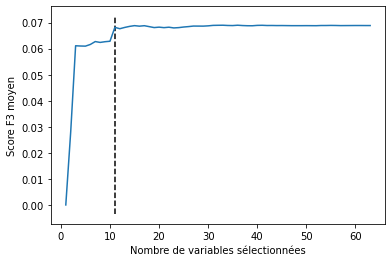

Nombre optimal de variables à sélectionner (coude) : 11
CPU times: user 34min 3s, sys: 50min 53s, total: 1h 24min 57s
Wall time: 17min 23s


In [10]:
%%time
model = LogisticRegression()
knee = run_RFECV(model, X_scaled, y, score=f3_scorer, knee=11, n_jobs=28)

Le nombre de features optimal semble être 11. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [11]:
%%time
model = LogisticRegression()
run_RFE(model, 11, X_scaled, y, export='RFECV_LR')

,Rank,Support
zonecostineuro,1,True
device_type_Desktop,1,True
display_env_app_ios,1,True
display_size,1,True
nbdisplay_1hour,1,True
is_interstitial_True,1,True
nbdayssincelastclick,1,True
campaignscenario_13,1,True
device_type_iPhone,1,True
campaignctrlast24h,1,True


Columns_quant :


['nbdisplay_1hour',
 'nbdayssincelastclick',
 'display_size',
 'campaignctrlast24h',
 'zonecostineuro']


Columns_cat :


['target_env_2',
 'is_interstitial_True',
 'display_env_app_ios',
 'device_type_iPhone',
 'device_type_Desktop',
 'campaignscenario_13']


Exportation : backups/RFECV_LR.json
CPU times: user 42min 49s, sys: 1h 15min 17s, total: 1h 58min 6s
Wall time: 8min 21s


## Random Forest

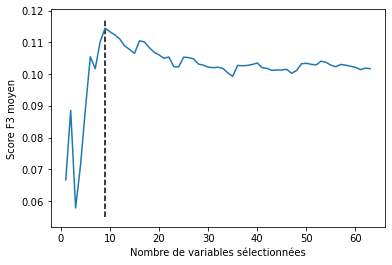

Nombre optimal de variables à sélectionner (coude) : 9
CPU times: user 3d 12h 3min 31s, sys: 15min 32s, total: 3d 12h 19min 4s
Wall time: 3h 42min 26s


In [12]:
%%time
model = RandomForestClassifier(n_jobs=28)
knee = run_RFECV(model, X, y, score=f3_scorer, n_jobs=1, knee=9)

Le nombre de features optimal semble être 9. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [13]:
%%time
model = RandomForestClassifier(n_jobs=28)
run_RFE(model, 9, X, y, export='RFECV_Forest')

,Rank,Support
contextid,1,True
campaignctrlast24h,1,True
dayssincelastvisitdouble,1,True
is_interstitial_True,1,True
nbdayssincelastclick,1,True
nbdisplay_1hour,1,True
nbdisplayglobalapprox_1d_sum_xdevice,1,True
display_size,1,True
zonecostineuro,1,True
weekday_Monday,2,False


Columns_quant :


['contextid',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'display_size',
 'campaignctrlast24h',
 'zonecostineuro',
 'dayssincelastvisitdouble']


Columns_cat :


['is_interstitial_True']


Exportation : backups/RFECV_Forest.json
CPU times: user 15h 4min 59s, sys: 3min 37s, total: 15h 8min 37s
Wall time: 38min 58s


## XGBoost

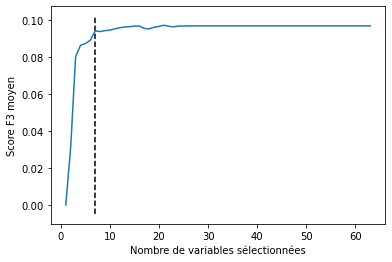

Nombre optimal de variables à sélectionner (coude) : 7
CPU times: user 1d 15h 42min 48s, sys: 10min 35s, total: 1d 15h 53min 24s
Wall time: 2h 24min 4s


In [14]:
%%time
model = XGBClassifier(n_jobs=28)
knee = run_RFECV(model, X, y, score=f3_scorer, n_jobs=1, knee=True)

In [15]:
%%time
model = XGBClassifier(n_jobs=28)
run_RFE(model, 8, X, y, export='RFECV_XGBoost')

,Rank,Support
contextid,1,True
campaignctrlast24h,1,True
device_type_iPad,1,True
device_type_Desktop,1,True
is_interstitial_True,1,True
nbdayssincelastclick,1,True
nbdisplay_1hour,1,True
zonecostineuro,1,True
campaignscenario_13,2,False
campaignvertical_23.0,3,False


Columns_quant :


['contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'campaignctrlast24h',
 'zonecostineuro']


Columns_cat :


['device_type_Desktop', 'is_interstitial_True', 'device_type_iPad']


Exportation : backups/RFECV_XGBoost.json
CPU times: user 5h 49min 50s, sys: 1min 1s, total: 5h 50min 51s
Wall time: 19min 18s


In [16]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 07:34:06
